In [1]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


In [2]:
## consts :

SAMPLE_FREQ = 50 
FILE_MARGINES = 5* SAMPLE_FREQ  ## number of samples to ignore in the  start and in the end of the file (5 seconds )  
WINDOW_SIZE = 128  ## sliding window size 

DEVICE_MODE_LABELS = ['pocket','swing','texting','whatever'] 
USER_MODE_LABELS = ['walking','fastwalking','stairs','static','whatever'] 

FEATURES = ['agforce','agyro','mgforce','mgyro','vgforce','vgyro','maxgforce','maxgyro','mingforce','minxgyro','ampgforce','ampxgyro']


### calulates high level features and add to given data frame 
#### add norm feature for g-force , gyro vectors 
#### calculates additional statistics features  on the norm properties using sliding window 
#### fill NaN values 

In [4]:
def addFeatures(df):
    
    ## norm calculations :
    df['gforce'] = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gyro'] = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2)     
    
    ## calculates statistics features on rolling window :
    
    df['agforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).mean()
    df['agyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).mean()

    df['mgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).median()
    df['mgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).median()

    df['vgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()
    df['vgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()

    df['maxgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).max()
    df['maxgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).max()

    df['mingforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).min()
    df['minxgyro']  = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).min()

    df['ampgforce'] = df['maxgforce'] - df['mingforce']
    df['ampxgyro']  = df['maxgyro'] - df['gyro']
    
    ## TODO : peaks detection , 
 

#### read csv data file , add label colomn by parsing the file name 
#### add high level features , crop file edges  
#### Todo : normlize , remove dc 

In [5]:
def loadFile(root,file):
    print 'loading : ' , file 
    data=pd.read_csv(os.path.join(root,file))
    
    ## usefull property : 
    data['source']=file  

    ## default label values in case file name not contains label  
    data['devicemodeDescription']=DEVICE_MODE_LABELS[-1] ## 'whatever' label 
    data['devicemode'] = len(DEVICE_MODE_LABELS)

    ## search device mode label in file name and add as new properties :
    for label in DEVICE_MODE_LABELS:
        if label.lower() in file.lower():  
            data['devicemodeDescription']=label         ## label name 
            data['devicemode'] = DEVICE_MODE_LABELS.index(label)    ## label index 
            break
    
    ## add high level features 
    addFeatures(data)
    
    print len(data) , ' samples loaded '
    print 'all records labeld as ', data['devicemodeDescription'][0]
        
    ## crop samples from start and from the end of the file :
    data.drop(data.index[range(0,FILE_MARGINES)],axis=0,inplace=True)
    data.drop(data.index[range(-FILE_MARGINES,-1)],axis=0,inplace=True)   
    print len(data) , ' samples after cropping ' , FILE_MARGINES , 'samples from start-end of the file  '
    return data

In [6]:
def loadFiles(inputDir):
    print 'loading files from : ' , inputDir 
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [7]:
rdf = loadFiles(r'../all-data/utf8')
print '========================================================='
print 'total train samples ' , len(rdf) 

loading files from :  ../all-data/utf8
loading :  SwingRightPhoneDownScBody.csv
9258  samples loaded 
all records labeld as  swing
8759  samples after cropping  250 samples from start-end of the file  
loading :  swing_walk2017-09-0316.04.51.csv
11775  samples loaded 
all records labeld as  swing
11276  samples after cropping  250 samples from start-end of the file  
loading :  texting_walk2017-09-0315.53.12.csv
4329  samples loaded 
all records labeld as  texting
3830  samples after cropping  250 samples from start-end of the file  
loading :  PocketLeftStairsUp3.csv
1219  samples loaded 
all records labeld as  pocket
720  samples after cropping  250 samples from start-end of the file  
loading :  swingLeftHandPhoneDownScBody.csv
10608  samples loaded 
all records labeld as  swing
10109  samples after cropping  250 samples from start-end of the file  
loading :  SwingRightPhoneDown.csv
7561  samples loaded 
all records labeld as  swing
7062  samples after cropping  250 samples from st

In [8]:
rdf.describe()

,Bx,By,Bz,I,Latitude,Longitude,Speed (m/s),Unnamed: 11,Unnamed: 12,Unnamed: 17,...,mgyro,mingforce,minxgyro,p,time,vgforce,vgyro,wx,wy,wz
count,130571.000000,130571.000000,130571.000000,69778.000000,15706.000000,15706.000000,15706.000000,0.0,0.0,0.0,...,130571.000000,130571.000000,130571.000000,109279.000000,130571.000000,1.305710e+05,1.305710e+05,130571.000000,130571.000000,130571.000000
mean,1.986717,12.570263,-6.945136,2270.310112,24.843007,26.677360,1.041270,NaN,NaN,NaN,...,1.435178,0.698914,0.498060,976.920210,102.995014,7.440947e-02,5.459917e-01,0.002345,0.004363,0.001885
std,24.832349,23.279281,22.305891,4209.896212,14.108547,15.150291,0.823378,NaN,NaN,NaN,...,0.792175,0.152582,0.349781,3.726151,65.528174,4.828065e-02,7.773395e-01,0.791472,1.034476,1.309384
min,-50.332600,-39.480000,-47.100000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.000316,0.344802,0.000224,968.814600,3.994000,1.101760e-07,2.620800e-08,-6.055000,-11.138600,-4.949600
25%,-16.500000,-6.292750,-26.507600,0.000000,32.854418,35.279376,0.000000,NaN,NaN,NaN,...,0.737756,0.592269,0.196065,977.880600,47.911000,3.765992e-02,1.082938e-01,-0.390800,-0.341300,-0.818500
50%,4.890400,20.393400,-16.645800,0.000000,32.854632,35.280320,1.500000,NaN,NaN,NaN,...,1.550985,0.693079,0.469738,978.492400,93.285000,6.865760e-02,3.238199e-01,0.000100,0.000100,0.000000
75%,24.691800,31.419400,14.259300,320.000000,32.854936,35.281420,1.750000,NaN,NaN,NaN,...,2.052036,0.784944,0.749069,978.732600,148.230000,1.143224e-01,6.412364e-01,0.337600,0.380700,0.834200
max,288.967900,65.843200,43.527200,10240.000000,32.857075,35.282055,2.250000,NaN,NaN,NaN,...,3.491192,1.012221,1.746989,980.680700,377.232000,2.311800e-01,7.656162e+00,5.633500,9.266700,5.048500


In [9]:
rdf.dropna(axis=1,inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130571 entries, 250 to 6823
Data columns (total 27 columns):
Bx                       130571 non-null float64
By                       130571 non-null float64
Bz                       130571 non-null float64
agforce                  130571 non-null float64
agyro                    130571 non-null float64
ampgforce                130571 non-null float64
ampxgyro                 130571 non-null float64
devicemode               130571 non-null int64
devicemodeDescription    130571 non-null object
gFy                      130571 non-null float64
gFz                      130571 non-null float64
gforce                   130571 non-null float64
gfx                      130571 non-null float64
gyro                     130571 non-null float64
maxgforce                130571 non-null float64
maxgyro                  130571 non-null float64
mgforce                  130571 non-null float64
mgyro                    130571 non-null float64
mingforce 

In [10]:
rdf.describe()

,Bx,By,Bz,agforce,agyro,ampgforce,ampxgyro,devicemode,gFy,gFz,...,mgforce,mgyro,mingforce,minxgyro,time,vgforce,vgyro,wx,wy,wz
count,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,...,130571.000000,130571.000000,130571.000000,130571.000000,130571.000000,1.305710e+05,1.305710e+05,130571.000000,130571.000000,130571.000000
mean,1.986717,12.570263,-6.945136,1.088779,1.485935,0.922021,1.281689,0.968799,-0.491682,0.261994,...,1.063494,1.435178,0.698914,0.498060,102.995014,7.440947e-02,5.459917e-01,0.002345,0.004363,0.001885
std,24.832349,23.279281,22.305891,0.084722,0.817407,0.444171,1.408978,0.697444,0.532280,0.421553,...,0.081327,0.792175,0.152582,0.349781,65.528174,4.828065e-02,7.773395e-01,0.791472,1.034476,1.309384
min,-50.332600,-39.480000,-47.100000,0.959846,0.000514,0.001182,0.000000,0.000000,-2.055800,-0.669800,...,0.850322,0.000316,0.344802,0.000224,3.994000,1.101760e-07,2.620800e-08,-6.055000,-11.138600,-4.949600
25%,-16.500000,-6.292750,-26.507600,1.016673,0.800246,0.649278,0.351012,0.000000,-0.844300,-0.048200,...,1.004779,0.737756,0.592269,0.196065,47.911000,3.765992e-02,1.082938e-01,-0.390800,-0.341300,-0.818500
50%,4.890400,20.393400,-16.645800,1.082335,1.596691,0.966101,0.925811,1.000000,-0.631200,0.090000,...,1.042157,1.550985,0.693079,0.469738,93.285000,6.865760e-02,3.238199e-01,0.000100,0.000100,0.000000
75%,24.691800,31.419400,14.259300,1.131694,2.062032,1.284633,1.724506,1.000000,-0.103500,0.578500,...,1.099206,2.052036,0.784944,0.749069,148.230000,1.143224e-01,6.412364e-01,0.337600,0.380700,0.834200
max,288.967900,65.843200,43.527200,1.492601,3.701527,1.980416,11.674745,2.000000,1.340800,1.761300,...,1.452724,3.491192,1.012221,1.746989,377.232000,2.311800e-01,7.656162e+00,5.633500,9.266700,5.048500


### visualize

In [11]:
cor_mat = rdf[FEATURES + ['devicemode']] .corr()
cor_mat

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro,devicemode
agforce,1.000000,0.625125,0.825650,0.732789,0.578337,0.086810,0.751228,0.304382,-0.060578,0.536806,0.609654,0.038463,-0.209917
agyro,0.625125,1.000000,0.511003,0.971507,0.591793,0.662819,0.589362,0.878796,-0.471358,0.737017,0.623888,0.584113,-0.716878
mgforce,0.825650,0.511003,1.000000,0.602579,0.502284,0.074701,0.559136,0.246040,-0.187020,0.409656,0.502520,0.030365,-0.117533
mgyro,0.732789,0.971507,0.602579,1.000000,0.617206,0.527663,0.653489,0.773408,-0.411753,0.712830,0.653679,0.459748,-0.651823
vgforce,0.578337,0.591793,0.502284,0.617206,1.000000,0.182243,0.882680,0.388177,-0.707731,0.597806,0.935003,0.165593,-0.259248
vgyro,0.086810,0.662819,0.074701,0.527663,0.182243,1.000000,0.077658,0.901017,-0.330835,0.314624,0.174520,0.811690,-0.570002
maxgforce,0.751228,0.589362,0.559136,0.653489,0.882680,0.077658,1.000000,0.313494,-0.496876,0.629328,0.954530,0.071500,-0.198383
maxgyro,0.304382,0.878796,0.246040,0.773408,0.388177,0.901017,0.313494,1.000000,-0.472483,0.559830,0.408038,0.806709,-0.720054
mingforce,-0.060578,-0.471358,-0.187020,-0.411753,-0.707731,-0.330835,-0.496876,-0.472483,1.000000,-0.406673,-0.732994,-0.345522,0.275350
minxgyro,0.536806,0.737017,0.409656,0.712830,0.597806,0.314624,0.629328,0.559830,-0.406673,1.000000,0.632995,0.307381,-0.475540


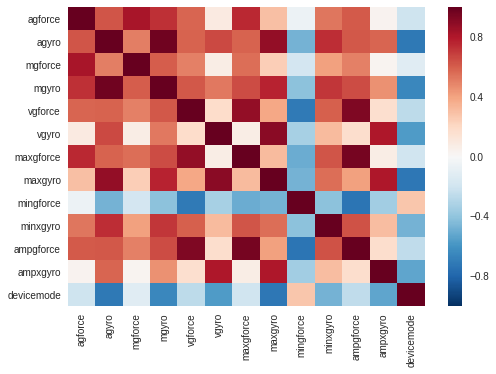

In [12]:
sns.heatmap(cor_mat)

## split train & test data

In [13]:
# take only relevants features :
df = rdf[FEATURES]
df.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.314327,2.358790,1.301040,2.631593,0.132965,0.680789,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
251,1.315529,2.364974,1.304636,2.631593,0.132745,0.674055,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
252,1.316730,2.371158,1.304636,2.631593,0.132521,0.667243,2.094436,3.294189,0.74283,0.618111,1.351606,1.076798
253,1.319528,2.373912,1.304636,2.631593,0.131412,0.662967,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887
254,1.322326,2.376665,1.304636,2.631593,0.130288,0.658675,2.094436,3.294189,0.74283,0.618111,1.351606,1.515887


In [14]:
x_train, x_test, y_train, y_test = train_test_split(df, rdf.devicemode, test_size=0.3, random_state=42,stratify=rdf.devicemode)

[[10139    16     2]
 [    7 20068     5]
 [    4     1  8930]]


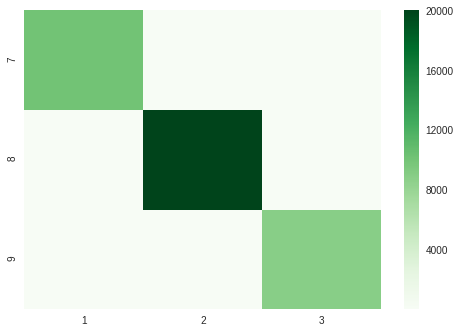

In [15]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train,y_train)
knn5_pred = knn5.predict(x_test)
print(confusion_matrix(y_pred=knn5_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_pred,y_true=y_test),cmap='Greens')

In [16]:
print('classification report results:\r\n' + classification_report(y_pred=knn5_pred,y_true=y_test))

classification report results:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     10157
          1       1.00      1.00      1.00     20080
          2       1.00      1.00      1.00      8935

avg / total       1.00      1.00      1.00     39172



In [17]:
accuracy_score(y_test,knn5_pred)

0.99910650464617579

### cross validation : 

In [18]:

def CalcKFoldAccuracy(classifier,X,Y,scoring,k):
    return cross_val_score(classifier, X, Y, cv=k, scoring=scoring).mean()

In [19]:
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()


In [20]:
k=5
scoring ='accuracy'
print ('KNN : ')
print (CalcKFoldAccuracy(knn5,x_train,y_train,scoring,k))
print ('RF : ')
print (CalcKFoldAccuracy(forest,x_train,y_train,scoring,k))
print ('Tree : ')
print (CalcKFoldAccuracy(tree,x_train,y_train,scoring,k))

KNN : 
0.998687075348
RF : 
0.999879648693
Tree : 
0.999212244251


### validate on file outside of the train bucket 

In [38]:
rvl = loadFiles(r'../raw-data/validation/utf8')
print '========================================================='
print 'total validation samples ' , len(rvl) 

loading files from :  ../raw-data/validation/utf8
loading :  swing3.csv
4931  samples loaded 
all records labeld as  swing
4432  samples after cropping  250 samples from start-end of the file  
loading :  Pocket2.csv
8050  samples loaded 
all records labeld as  pocket
7551  samples after cropping  250 samples from start-end of the file  
loading :  Texting2.csv
4268  samples loaded 
all records labeld as  texting
3769  samples after cropping  250 samples from start-end of the file  
total validation samples  15752


In [39]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,...,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,5.575,-0.7754,-0.6393,-0.0722,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.998835,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
251,5.576,-0.8192,-0.6118,-0.1383,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.999904,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
252,5.616,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
253,5.617,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
254,5.638,-0.7282,-0.6251,-0.0240,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,1.000973,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323


In [42]:
vl = rvl[FEATURES]
vl.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.009667,0.826034,0.998835,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
251,1.011935,0.814236,0.999904,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
252,1.014203,0.804996,1.000973,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
253,1.016724,0.795755,1.000973,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
254,1.018685,0.786515,1.000973,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323


In [48]:
k=5
scoring ='accuracy'

print ('KNN : ')
knn5_val = knn5.predict(vl)
print(confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode))
##sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode),cmap='Greens')
print(classification_report(y_pred=knn5_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,knn5_val)
print '========================================================='

print ('RF : ')
forest.fit(x_train,y_train)
print(confusion_matrix(y_pred=forest_val,y_true=rvl.devicemode))
forest_val = forest.predict(vl)
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,forest_val)
print '========================================================='

print ('TREE : ')
tree.fit(x_train,y_train)
tree_val = tree.predict(vl)
print(classification_report(y_pred=tree_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,tree_val)

KNN : 
[[5468 2041   42]
 [  16 4356   60]
 [   0    2 3767]]
             precision    recall  f1-score   support

          0       1.00      0.72      0.84      7551
          1       0.68      0.98      0.80      4432
          2       0.97      1.00      0.99      3769

avg / total       0.90      0.86      0.86     15752

RF : 
[[1060 6444   47]
 [  22 4354   56]
 [   0    0 3769]]
             precision    recall  f1-score   support

          0       1.00      0.76      0.86      7551
          1       0.71      0.99      0.83      4432
          2       0.98      1.00      0.99      3769

avg / total       0.91      0.88      0.88     15752

TREE : 
             precision    recall  f1-score   support

          0       0.99      0.75      0.85      7551
          1       0.70      0.98      0.82      4432
          2       0.98      1.00      0.99      3769

avg / total       0.91      0.87      0.88     15752



0.8744286439817166

In [47]:
x_train.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
1994,1.135156,1.579327,1.068464,1.536313,1.105802e-01,8.786274e-02,2.106544,2.014172,0.636908,1.050155,1.469636,0.261767
4932,0.996321,0.469447,1.006513,0.430819,3.998869e-02,6.369809e-02,1.287416,1.244825,0.682482,0.158289,0.604934,1.059689
5047,1.097108,2.127410,1.193731,1.919606,1.615278e-01,7.565414e-01,1.772092,4.145757,0.368174,0.754670,1.403918,3.014713
6625,1.239763,2.053971,1.249644,2.006866,1.364100e-01,4.715001e-01,2.045321,3.165397,0.648441,0.672347,1.396880,0.485613
4229,0.983090,0.000778,0.983137,0.000812,4.521440e-07,1.221559e-07,0.984156,0.001503,0.981938,0.000332,0.002217,0.001172


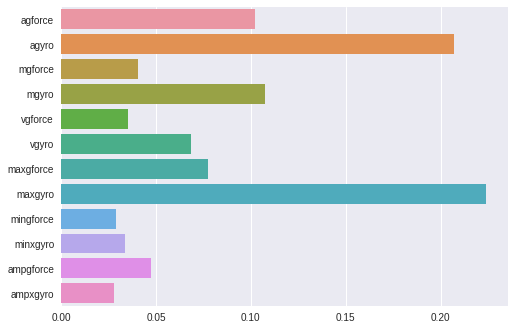

In [46]:
sns.barplot(y=x_test.columns,x=forest.feature_importances_,orient="h" )